
### Problem Statement:
**Informed Question:** How can we leverage data on dog owners in Zurich, population demographics, income levels, and household sizes across 34 neighborhoods to gain insights into dog ownership patterns, predict future trends, and provide actionable recommendations for stakeholders?

### Context:
The city of Zurich is undertaking a comprehensive exploration of dog ownership dynamics within its neighborhoods. In response to a gradual shift in popularity from larger to smaller breed dogs, coupled with a notable uptick in pet dog ownership since the removal of mandatory dog training course requirements in 2017, the city aims to inform urban planning, support pet service businesses, and enhance the overall well-being of residents and their pets. The analysis focuses on uncovering spatial patterns, identifying factors influencing dog ownership, and offering predictive insights for future planning. This project seeks to understand and leverage data, providing valuable insights into dog ownership patterns across the 34 administrative districts of Zurich. It will examine the dynamic interplay between demographic factors, such as population density, household size, and income level, with the prevalence of dog ownership. The ultimate objective is to uncover trends, identify business opportunities in the pet dog services sector, and offer tailored, data-driven insights for businesses in each neighborhood.

### Criteria for Success:
The project will be considered successfully completed when the predictive models consistently achieve a Mean Absolute Error (MAE) below 10% in forecasting the number of dog owners in Zurich's 34 neighborhoods from 2015 to 2023.

### Constraints within Solution Space:
- **Breed Consideration:** The analysis will consider data for pure breed dogs, excluding mix breed dogs to avoid potential confusions and complexities.
- **Temporal Constraints:** The analysis and modeling efforts are constrained to the overlapping years from 2015 due to data availability.
   
### Stakeholders:
- **City Planners:** Interested in understanding spatial patterns to inform urban planning policies.
- **Businesses:** Seeking insights for marketing strategies and service offerings related to pet services.
- **Local Authorities:** Interested in enhancing the well-being of residents and their pets through informed decisions.
- **Pet Owners**: Puppies should be able to socialize with other dogs of the same or similar breed. In Switzerland, it is recommended that dogs have contact with humans every day, and if possible, with other dogs. Additionally, it is recommended to not leave your pet dog alone for more than four hours at a time.
   
### Key Data Sources:
- **Dog Owners Data:** [Link to Dog Owners Data](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv)
- **Population Data:** [Link to Population Data](https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv)
- **Income Data:** [Link to Income Data](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv)
- **Household Data:** [Link to Household Data](https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv)

These data sources will serve as the foundation for our spatial data science analysis, providing insights into dog ownership patterns, demographics, income levels, and household sizes across Zurich's neighborhoods.

### Exploring Spatial Dynamics of Dog Ownership in Zurich

#### Problem Statement:
**Informed Question:** How can we strategically leverage data on dog owners in Zurich, population demographics, income levels, and household sizes across 34 neighborhoods to gain insights into dog ownership patterns, predict future trends, and provide actionable recommendations for stakeholders?

#### Context:
The city of Zurich is embarking on a comprehensive exploration of dog ownership dynamics within its neighborhoods. This initiative responds to a gradual shift in popularity from larger to smaller breed dogs, coupled with a noticeable uptick in pet dog ownership since the removal of mandatory dog training course requirements in 2017. The city's objectives are to inform urban planning, support pet service businesses, and enhance the overall well-being of residents and their pets. Our analysis focuses on uncovering spatial patterns, identifying factors influencing dog ownership, and offering predictive insights for future planning.

#### Criteria for Success:
The project will be considered successfully completed when the predictive models consistently achieve a Mean Absolute Error (MAE) below 10% in forecasting the number of dog owners in Zurich's 34 neighborhoods from 2015 to 2023.

#### Constraints within Solution Space:
- **Breed Consideration:** The analysis will consider data for pure breed dogs, excluding mix breed dogs to avoid potential confusions and complexities.
- **Temporal Constraints:** The analysis and modeling efforts are constrained to the overlapping years from 2015 due to data availability.

#### Stakeholders:
- **City Planners:** Interested in understanding spatial patterns to inform urban planning policies.
- **Businesses:** Seeking insights for marketing strategies and service offerings related to pet services.
- **Local Authorities:** Interested in enhancing the well-being of residents and their pets through informed decisions.
- **Pet Owners:** Seeking insights to ensure puppies can socialize effectively, and dogs receive appropriate contact and care.

#### Key Data Sources:
- **Dog Owners Data:** [Link to Dog Owners Data](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv)
- **Population Data:** [Link to Population Data](https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv)
- **Income Data:** [Link to Income Data](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv)
- **Household Data:** [Link to Household Data](https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv)

These combined data sources will serve as the foundation for our spatial data science analysis, providing insights into dog ownership patterns, demographics, income levels, and household sizes across Zurich's neighborhoods.


# Spatial Analysis of Dog Ownership in Zurich

## Overview

This notebook explores the spatial dynamics of dog ownership in Zurich, Switzerland. Leveraging datasets on dog owners, population demographics, income levels, household sizes, and neighborhood geometry, we aim to gain insights into dog ownership patterns, forecast future trends, and deliver actionable recommendations for stakeholders for the current year.

## Problem Statement

How can we strategically utilize data on dog owners, population demographics, income levels, and household sizes across 34 neighborhoods in Zurich to comprehend dog ownership patterns, forecast future trends, and deliver actionable recommendations for stakeholders for this year?

### SMART Criteria

- **Specific:** Understand and interpret patterns of dog ownership in Zurich, forecasting trends for the current year.
- **Measurable:** Utilize quantitative metrics such as predictive models, spatial analysis indicators, and demographic insights.
- **Achievable:** Leverage available datasets and analytical tools to provide realistic and actionable recommendations.
- **Relevant:** Address the specific needs of stakeholders, including businesses, urban planners, and policymakers in Zurich.
- **Time-bound:** Deliver insights and recommendations applicable for the current year.

## Key Objectives

- Understand the current distribution of dog breeds across Zurich's neighborhoods.
- Apply predictive modeling to forecast changes in the distribution of dog breeds.
- Identify localized patterns using spatial analysis techniques like LISA (Local Indicators of Spatial Association).
- Provide recommendations for businesses, urban planners, and policymakers based on spatial insights.


## Datasets Used

1. Dog Owners Data
2. Population Demographics Data
3. Income Levels Data
4. Household Sizes Data
5. Neighborhood Geometry Data

## Analysis Tools

- Python
- Pandas for data manipulation
- GeoPandas for spatial data analysis
- Matplotlib and Seaborn for data visualization
- Scikit-learn for predictive modeling

## Project Timeline

- Data Cleaning and Preparation
- Exploratory Data Analysis (EDA)
- Spatial Analysis
- Predictive Modeling
- Recommendations and Insights

Feel free to explore the notebook to dive into the details of our analysis and findings.


In [126]:
import re
from typing import Optional, Callable
from pathlib import Path
from urllib.request import urlopen
from fiona.io import ZipMemoryFile
import numpy as np
import pandas as pd
import geopandas as gpd
import geoviews as gv
from thefuzz import fuzz
import hvplot
import hvplot.pandas
import holoviews as hv
from holoviews import streams
import colorcet as cc
import cartopy.crs as ccrs
import panel as pn
import panel.widgets as pnw
import seaborn as sns
from wordcloud import WordCloud
from PIL import ImageDraw, Image

from translate_app import translate_list_to_dict

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
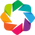

In [201]:
# suppress warnings
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
gv.extension("bokeh")
hv.extension("bokeh")
hvplot.extension("bokeh")
pn.extension()

pn.config.throttled = True

In [128]:
def convert_to_snake_case(item):
    # Add _ before uppercase in camelCase
    s1 = re.sub(r"(.)([A-Z][a-z]+)", r"\1_\2", item)
    # Add _ before uppercase following lowercase or digit
    s2 = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", s1)
    # Add _ between letter and digit
    s3 = re.sub(r"([a-zA-Z])([0-9])", r"\1_\2", s2)
    s4 = re.sub(r"[-\s]", "_", s3).lower()  # Replace hyphen or space with _
    return s4


def sanitize_df_column_names(df):
    """Function to danitize column names by translating and conveting to snake case"""
    column_list = df.columns.tolist()
    # translate the column names
    translated_dict = translate_list_to_dict(column_list)
    # map the translated column names to the column names
    df.rename(columns=translated_dict, inplace=True)
    # convert the column names to snake case
    df.columns = [convert_to_snake_case(col) for col in df.columns]
    return df

In [129]:
def get_gdf_from_zip_url(zip_url: str) -> Optional[dict[str, gpd.GeoDataFrame]]:
    """Function to get the geojson data from the zip url.
    In the zip url, the geojson files are in the data folder."""
    gpd_dict = {}

    with urlopen(zip_url) as u:
        zip_data = u.read()
    with ZipMemoryFile(zip_data) as z:
        geofiles = z.listdir("data")
        for file in geofiles:
            with z.open("data/" + file) as g:
                gpd_dict[Path(file).stem] = gpd.GeoDataFrame.from_features(
                    g, crs=g.crs)
    return gpd_dict if gpd_dict else None


def rename_keys(d, prefix="zurich_gdf_"):
    return {f"{prefix}{i}": v for i, (k, v) in enumerate(d.items())}

In [130]:
def find_breed_match(
    input_breed: str,
    breeds_df: pd.DataFrame,
    scoring_functions: list[Callable[[str, str], int]],
    scoring_threshold: int = 85,
) -> Optional[str]:
    """
    Find the match for the breed in the FCI breeds dataframe.
    breeds_df dataframe must have both a breed_en and alt_names column.
    """
    # Initialize the maximum score and best match
    max_score = scoring_threshold
    best_match = None

    # Iterate over each row in the breeds dataframe
    for index, breed_row in breeds_df.iterrows():
        # Get the alternative names for the current breed
        alternative_names = breed_row["alt_names"]

        # Calculate the score for the input breed and each alternative name
        # using each scoring function, and take the maximum of these scores
        current_score = max(
            max(
                scoring_function(input_breed, alt_name)
                for scoring_function in scoring_functions
            )
            for alt_name in alternative_names
        )
        # If the current score is greater than the maximum score, update the
        # maximum score and best match
        if current_score > max_score:
            max_score = current_score
            best_match = breed_row["breed_en"]

        # If the maximum score is 100, we have a perfect match and can break
        # out of the loop early
        if max_score == 100:
            break

    # Return the best match
    return best_match


def apply_fuzzy_matching_to_breed_column(
    dataframe: pd.DataFrame,
    breed_column: str,
    fci_df: pd.DataFrame,
    scoring_functions: list[Callable[[str, str], int]],
    scoring_threshold: int = 85,
) -> pd.Series:
    """Apply fuzzy matching to the breed column in the dataframe."""

    return dataframe[breed_column].apply(
        lambda breed: find_breed_match(
            breed, fci_df, scoring_functions, scoring_threshold=scoring_threshold
        )
    )

#### Zurich Dogs Dataset
In this dataset you will find information on dogs and their owners from the owners of the municipal dog register since 2015. In the case of dog owners, information on the age group, gender and statistical neighbourhood of the place of residence is provided. For each dog, the breed, the breed type, the sex, the year of birth, the age and the color is recorded. The dog register is maintained by the Dog Control Department of the Zurich City Police.

According to the law on the keeping of dogs, the city police are obliged to keep a register of dogs kept in the city of Zurich. Every dog over the age of three months must be registered at the dog control by the owner in person or by means of the registration form.

In [158]:
zurich_dog_data_link = "https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand_od1001/download/KUL100OD1001.csv"
zurich_dog_data = pd.read_csv(zurich_dog_data_link)
zurich_dog_data = sanitize_df_column_names(zurich_dog_data)
zurich_dog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70967 entries, 0 to 70966
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   deadline_date_year       70967 non-null  int64 
 1   data_status_cd           70967 non-null  object
 2   holder_id                70967 non-null  int64 
 3   age_v_10_cd              70967 non-null  int64 
 4   age_v_10_long            70967 non-null  object
 5   age_v_10_sort            70967 non-null  int64 
 6   sex_cd                   70967 non-null  int64 
 7   sex_long                 70967 non-null  object
 8   sex_sort                 70967 non-null  int64 
 9   circle_cd                70967 non-null  int64 
 10  circle_lang              70967 non-null  object
 11  circle_sort              70967 non-null  int64 
 12  quar_cd                  70967 non-null  int64 
 13  quar_lang                70967 non-null  object
 14  quar_sort                70967 non-nul

In [159]:
zurich_dog_data["breed_mixed__breed_sort"].value_counts()
breed_cat_list_de = zurich_dog_data["breed_mongrel_long"].unique().tolist()
breed_cat_dict = translate_list_to_dict(breed_cat_list_de)

zurich_dog_data["mixed_type"] = zurich_dog_data["breed_mongrel_long"].map(
    breed_cat_dict
)
zurich_dog_data["owner_id"] = zurich_dog_data["holder_id"].astype(str).str.zfill(6)
zurich_dog_data

,deadline_date_year,data_status_cd,holder_id,age_v_10_cd,age_v_10_long,age_v_10_sort,sex_cd,sex_long,sex_sort,circle_cd,circle_lang,circle_sort,quar_cd,quar_lang,quar_sort,race_1_text,race_2_text,breed_mixed__breed_cd,breed_mongrel_long,breed_mixed__breed_sort,breed_type_cd,breed_type_long,breed__type_sort,birth_dog_year,age_v_dog_cd,age_v_dog_long,age_v_dog_sort,sex_dog_cd,sex_dog_long,sex_dog_sort,dog_color_text,number_of_dogs,mixed_type,owner_id
0,2015,D,126,60,60- bis 69-Jährige,7,1,männlich,1,9,Kreis 9,9,92,Altstetten,92,Welsh Terrier,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2011,3,3-Jährige,3,2,weiblich,2,schwarz/braun,1,Pedigree dog,000126
1,2015,D,574,60,60- bis 69-Jährige,7,2,weiblich,2,2,Kreis 2,2,23,Leimbach,23,Cairn Terrier,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2002,12,12-Jährige,12,2,weiblich,2,brindle,1,Pedigree dog,000574
2,2015,D,695,40,40- bis 49-Jährige,5,1,männlich,1,6,Kreis 6,6,63,Oberstrass,63,Labrador Retriever,Keine,1,Rassehund,1,I,Rassentypenliste I,2,2012,2,2-Jährige,2,2,weiblich,2,braun,1,Pedigree dog,000695
3,2015,D,893,60,60- bis 69-Jährige,7,2,weiblich,2,7,Kreis 7,7,71,Fluntern,71,Mittelschnauzer,Keine,1,Rassehund,1,I,Rassentypenliste I,2,2010,4,4-Jährige,4,2,weiblich,2,schwarz,1,Pedigree dog,000893
4,2015,D,1177,50,50- bis 59-Jährige,6,1,männlich,1,10,Kreis 10,10,102,Wipkingen,102,Shih Tzu,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2011,3,3-Jährige,3,1,männlich,1,schwarz/weiss,1,Pedigree dog,001177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70962,2023,P,163270,30,30- bis 39-Jährige,4,2,weiblich,2,9,Kreis 9,9,91,Albisrieden,91,Holländischer Schäfer,Keine,1,Rassehund,1,I,Rassentypenliste I,2,2019,3,3-Jährige,3,1,männlich,1,gestromt,1,Pedigree dog,163270
70963,2023,P,163274,50,50- bis 59-Jährige,6,2,weiblich,2,10,Kreis 10,10,102,Wipkingen,102,Pudel,Labrador Retriever,2,"Mischling, beide Rassen bekannt",2,I,Rassentypenliste I,2,2023,0,0-Jährige,0,2,weiblich,2,schwarz/weiss,1,"Mixed breed, both breeds known",163274
70964,2023,P,163275,50,50- bis 59-Jährige,6,2,weiblich,2,4,Kreis 4,4,42,Langstrasse,42,Bichon à poil frisé,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2021,1,1-Jährige,1,1,männlich,1,weiss,1,Pedigree dog,163275
70965,2023,P,163276,20,20- bis 29-Jährige,3,2,weiblich,2,3,Kreis 3,3,33,Friesenberg,33,Malteser,Keine,1,Rassehund,1,K,Kleinwüchsig,1,2022,0,0-Jährige,0,2,weiblich,2,beige,1,Pedigree dog,163276


In [160]:
# rename the mixed types to something more manageable
zurich_dog_data["mixed_type"] = zurich_dog_data["mixed_type"].map(
    {
        "Pedigree dog": "PB",
        "Mixed breed, both breeds known": "BB",
        "Mixed breed, secondary breed unknown": "BU",
        "Mixed breed, both breeds unknown": "UU",
    }
)

In [161]:
zurich_dog_data["is_male_owner"] = zurich_dog_data["sex_cd"] == 1
zurich_dog_data["is_male_dog"] = zurich_dog_data["sex_dog_cd"] == 1
zurich_dog_data["age_group_10"] = zurich_dog_data["age_v_10_cd"].copy()
zurich_dog_data["age_group_10s"] = zurich_dog_data["age_group_10"].astype(str) + "s"
zurich_dog_data["dog_age"] = (
    zurich_dog_data["deadline_date_year"] - zurich_dog_data["birth_dog_year"] + 1
)
zurich_dog_data["district"] = zurich_dog_data["circle_cd"].copy()
zurich_dog_data["sub_district"] = (
    zurich_dog_data["quar_cd"].copy().astype(str).str.zfill(3)
)
zurich_dog_data["breed_type"] = zurich_dog_data["breed_type_cd"].copy()
zurich_dog_data["roster"] = zurich_dog_data["deadline_date_year"].copy()
zurich_dog_data["dog_count"] = zurich_dog_data.groupby(["owner_id", "roster"])[
    "number_of_dogs"
].transform(np.sum)
zurich_dog_data["is_pure_breed"] = (
    zurich_dog_data["breed_mixed__breed_sort"].copy() == 1
)
zurich_dog_data["is_mixed_breed"] = ~zurich_dog_data["is_pure_breed"]
zurich_dog_data["breed_1"] = zurich_dog_data["race_1_text"].copy()
zurich_dog_data["breed_2"] = zurich_dog_data["race_2_text"].copy()
zurich_dog_data["neighborhood"] = zurich_dog_data["quar_lang"].copy()
zurich_dog_data["dog_color"] = zurich_dog_data["dog_color_text"].copy()

columns_of_interest = [
    "owner_id",
    "is_male_owner",
    "is_male_dog",
    "age_group_10s",
    "dog_age",
    "district",
    "sub_district",
    "breed_type",
    "roster",
    "dog_count",
    "number_of_dogs",
    "is_pure_breed",
    "mixed_type",
    "breed_1",
    "breed_2",
    "neighborhood",
    "dog_color",
]
dog_data = zurich_dog_data[columns_of_interest].copy()

In [162]:
dog_data.query('breed_1.str.contains(r".*doodle", regex=True, na=False, case=False)')[
    ["is_pure_breed", "breed_1", "breed_2"]
]

,is_pure_breed,breed_1,breed_2
4057,True,$Labradoodle$,Keine
4425,True,$Labradoodle$,Keine
5203,True,$Labradoodle$,Keine
5419,True,$Labradoodle$,Keine
5479,True,$Labradoodle$,Keine
5556,False,$Labradoodle$,Pudel
5695,True,$Labradoodle$,Keine
6405,True,$Labradoodle$,Keine
6539,True,$Labradoodle$,Keine
6765,True,$Labradoodle$,Keine


In [164]:
# create mask to filter out the doodle dogs
doodle_mask = dog_data["breed_1"].str.contains(
    r".*doodle", regex=True, na=False, case=False
)
# convert them to mixed breed if they are pure breeds
dog_data.loc[doodle_mask, "is_pure_breed"] = False
dog_data.loc[doodle_mask, "breed_2"] = "Pudel"
dog_data.loc[doodle_mask, "breed_1"] = dog_data.loc[doodle_mask, "breed_1"].apply(
    lambda x: "Golden Retriever" if x.startswith("G") else "Labrador Retriever"
)
# dog_data[doodle_mask]

In [166]:
dog_colors = dog_data["dog_color"].unique().tolist()

# {color for clist in dog_colors for color in clist if color is not None}
dog_colors[:5]

['schwarz/braun', 'brindle', 'braun', 'schwarz', 'schwarz/weiss']

In [167]:
dog_colors_df = pd.DataFrame(
    dog_data["dog_color"].unique().tolist(), columns=["dog_color"]
)
dog_colors_df["dog_color"] = dog_colors_df["dog_color"].str.lower()

In [170]:
color_translations = translate_list_to_dict(dog_colors_df["dog_color"].tolist())
dog_colors_df["dog_color_en"] = dog_colors_df["dog_color"].map(color_translations)
dog_colors_df

,dog_color,dog_color_translation,dog_color_en
0,schwarz/braun,black/brown,black/brown
1,brindle,brindle,brindle
2,braun,brown,brown
3,schwarz,black,black
4,schwarz/weiss,black-and-white,black-and-white
...,...,...,...
209,braun creme,brown cream,brown cream
210,champaigne,champagne,champagne
211,pink/chocolate,pink/chocolate,pink/chocolate
212,dapple,dapple,dapple


In [171]:
dog_data.merge(dog_colors_df, on="dog_color", how="left")

,owner_id,is_male_owner,is_male_dog,age_group_10s,dog_age,district,sub_district,breed_type,roster,dog_count,number_of_dogs,is_pure_breed,mixed_type,breed_1,breed_2,neighborhood,dog_color,dog_color_translation,dog_color_en
0,000126,True,False,60s,5,9,092,K,2015,1,1,True,PB,Welsh Terrier,Keine,Altstetten,schwarz/braun,black/brown,black/brown
1,000574,False,False,60s,14,2,023,K,2015,1,1,True,PB,Cairn Terrier,Keine,Leimbach,brindle,brindle,brindle
2,000695,True,False,40s,4,6,063,I,2015,1,1,True,PB,Labrador Retriever,Keine,Oberstrass,braun,brown,brown
3,000893,False,False,60s,6,7,071,I,2015,1,1,True,PB,Mittelschnauzer,Keine,Fluntern,schwarz,black,black
4,001177,True,True,50s,5,10,102,K,2015,1,1,True,PB,Shih Tzu,Keine,Wipkingen,schwarz/weiss,black-and-white,black-and-white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70976,163270,False,True,30s,5,9,091,I,2023,1,1,True,PB,Holländischer Schäfer,Keine,Albisrieden,gestromt,brindle,brindle
70977,163274,False,False,50s,1,10,102,I,2023,1,1,False,BB,Pudel,Labrador Retriever,Wipkingen,schwarz/weiss,black-and-white,black-and-white
70978,163275,False,True,50s,3,4,042,K,2023,1,1,True,PB,Bichon à poil frisé,Keine,Langstrasse,weiss,white,white
70979,163276,False,False,20s,2,3,033,K,2023,1,1,True,PB,Malteser,Keine,Friesenberg,beige,beige,beige


In [172]:
breeds_df = pd.DataFrame(
    dog_data["breed_1"].unique().tolist(), columns=["breed"])
breeds_df["breed"] = breeds_df["breed"].str.lower()

In [173]:
breeds_translations = translate_list_to_dict(breeds_df["breed"].tolist())
breeds_df["translation"] = breeds_df["breed"].map(breeds_translations)
breeds_df

,breed,translation
0,welsh terrier,welsh terrier
1,cairn terrier,cairn terrier
2,labrador retriever,labrador retrievers
3,mittelschnauzer,medium schnauzer
4,shih tzu,shih tzu
...,...,...
387,pudelpointer,poodle pointer
388,stabijhoun,stabijhoun
389,altdeutscher hütehund,old german herding dog
390,montenegrinischer gebirgslaufhund,Montenegrin mountain hound


In [174]:
dog_data.dtypes
dog_data.sample().T

,18004
owner_id,114132
is_male_owner,False
is_male_dog,False
age_group_10s,60s
dog_age,3
district,12
sub_district,122
breed_type,K
roster,2017
dog_count,1


In [138]:
# dog_data.query("dog_count==13 ")
# dog_data.query("is_pure_breed")["breed_1"].value_counts()
fci_breeds = pd.read_json("../data/fci_breeds.json")
fci_breeds[["alt_names", "breed_en"]]

,alt_names,breed_en
0,"[perro de pastor islandes, islandhund, islensk...",icelandic sheepdog
1,"[jämthund, schwedischer elchhund, perro cazado...",jämthund
2,"[perro de pastor yugoslavo de charplanina, yug...",yugoslavian shepherd dog - sharplanina
3,"[terrier jack russell, terrier jack russell , ...",jack russell terrier
4,"[fila brasileno, fila brasileño, fila brasileiro]",fila brasileiro
...,...,...
351,"[slovensky hrubosrsty stavac ohar, braque slov...",wirehaired slovakian pointer
352,"[svensk lapphund, perro sueco de laponia, lapp...",swedish lapphund
353,[shih tzu],shih tzu
354,[shar pei],shar pei


In [106]:
breeds_df["standard"] = None
# create a nan mask
nan_mask = breeds_df["standard"].isna()
print(f"Nan values: {nan_mask.sum()}")

# match for each column
for col in ["breed", "translation"]:
    matched_value = apply_fuzzy_matching_to_breed_column(
        breeds_df.loc[nan_mask], col, fci_breeds, [fuzz.WRatio]
    )
    breeds_df.loc[nan_mask, "standard"] = matched_value[nan_mask]
    nan_mask = breeds_df["standard"].isna()

    print(f"Nan values: {nan_mask.sum()}")

breeds_df

Nan values: 392
Nan values: 26
Nan values: 13


,breed,translation,standard
0,welsh terrier,welsh terrier,welsh terrier
1,cairn terrier,cairn terrier,cairn terrier
2,labrador retriever,labrador retrievers,labrador retriever
3,mittelschnauzer,medium schnauzer,schnauzer
4,shih tzu,shih tzu,shih tzu
...,...,...,...
387,pudelpointer,poodle pointer,pudelpointer
388,stabijhoun,stabijhoun,stabijhoun
389,altdeutscher hütehund,old german herding dog,yugoslavian shepherd dog - sharplanina
390,montenegrinischer gebirgslaufhund,Montenegrin mountain hound,montenegrin mountain hound


In [111]:
breeds_df.loc[breeds_df["breed"] == "elo", "standard"] = None
breeds_df.loc[breeds_df["breed"] == "unbekannt", "standard"] = 'mixed'
breeds_df.loc[breeds_df["breed"] == "mischling", "standard"] = 'mixed'

breeds_df.loc[breeds_df.standard.isnull()]

,breed,translation,standard
14,unbekannt,unknown,None
38,bolonka zwetna,bolonka zwetna,None
116,alaskan husky,Alaskan Husky,None
133,rehpinscher,rehpinscher,None
198,ratenero bodeguero,ratenero bodeguero,None
214,toller,more awesome,None
216,elo,elo,None
246,bardino,bardino,None
277,ratero,ratero,None
302,wäller,waller,None


In [125]:
fci_breeds.query('breed_en.str.contains(r"bo", case=False)')

,breed_text,link,breed_group,breed_translations,subsection,section,date_of_acceptance,country_of_origin,varieties,fci_num,breed,alt_names,breed_en,n_varieties,group_num,group_name,no_accent
97,DOGUE DE BORDEAUX\r\n\t\t\t(116),https://fci.be/en/nomenclature/DOGUE-DE-BORDEA...,n°2 - Pinscher and Schnauzer - Molossoid and S...,"[DOGUE DE BORDEAUX, DOGUE DE BORDEAUX, BORDEAU...",Mastiff type,Molossian type,1/1/1954,[FRANCE],[],116,DOGUE DE BORDEAUX,"[dogo de burdeos, bordeauxdogge, dogue de bord...",dogue de bordeaux,0,2,Pinscher and Schnauzer - Molossoid and Swiss M...,"[dogue de bordeaux, dogue de bordeaux, bordeau..."
111,DEUTSCHER BOXER\r\n\t\t\t(144),https://fci.be/en/nomenclature/BOXER-144.html,n°2 - Pinscher and Schnauzer - Molossoid and S...,"[BOXER, BOXER, DEUTSCHER BOXER, BOXER]",Mastiff type,Molossian type,1/1/1955,[GERMANY],"[fawn, brindle]",144,DEUTSCHER BOXER,"[boxer, deutscher boxer]",boxer,2,2,Pinscher and Schnauzer - Molossoid and Swiss M...,"[boxer, boxer, deutscher boxer, boxer, deutsch..."
154,BOLOGNESE\r\n\t\t\t(196),https://fci.be/en/nomenclature/BOLOGNESE-196.html,n°9 - Companion and Toy Dogs,"[BOLOGNESE, BICHON BOLONAIS, BOLOGNESER, BOLOG...",Bichons,Bichons and related breeds,3/5/1956,[ITALY],[],196,BOLOGNESE,"[bolognese, bologneser, bichon bolonais]",bolognese,0,9,Companion and Toy Dogs,"[bolognese, bichon bolonais, bologneser, bolog..."
164,BOUVIER DES FLANDRES-VLAAMSE KOEHOND\r\n\t\t\t...,https://fci.be/en/nomenclature/BOUVIER-DES-FLA...,n°1 - Sheepdogs and Cattledogs (except Swiss C...,"[BOUVIER DES FLANDRES, BOUVIER DES FLANDRES, F...",None,Cattledogs (except Swiss Cattledogs),11/1/1955,"[BELGIUM, FRANCE]",[],191,BOUVIER DES FLANDRES-VLAAMSE KOEHOND,"[bouvier des flandres, flandrischer treibhund,...",bouvier des flandres,0,1,Sheepdogs and Cattledogs (except Swiss Cattled...,"[bouvier des flandres, bouvier des flandres, f..."
167,BOUVIER DES ARDENNES\r\n\t\t\t(171),https://fci.be/en/nomenclature/BOUVIER-DES-ARD...,n°1 - Sheepdogs and Cattledogs (except Swiss C...,"[BOUVIER DES ARDENNES, BOUVIER DES ARDENNES, A...",None,Cattledogs (except Swiss Cattledogs),6/13/1955,[BELGIUM],[],171,BOUVIER DES ARDENNES,"[ardennen-treibhund, bouvier des ardennes, boy...",bouvier des ardennes,0,1,Sheepdogs and Cattledogs (except Swiss Cattled...,"[bouvier des ardennes, bouvier des ardennes, a..."
175,BOSTON TERRIER\r\n\t\t\t(140),https://fci.be/en/nomenclature/BOSTON-TERRIER-...,n°9 - Companion and Toy Dogs,"[BOSTON TERRIER, TERRIER DE BOSTON, BOSTON TER...",None,Small Molossian type Dogs,1/29/1955,[UNITED STATES OF AMERICA],[],140,BOSTON TERRIER,"[terrier de boston, boston terrier]",boston terrier,0,9,Companion and Toy Dogs,"[boston terrier, terrier de boston, boston ter..."
176,BRAQUE DU BOURBONNAIS\r\n\t\t\t(179),https://fci.be/en/nomenclature/BOURBONNAIS-POI...,n°7 - Pointing Dogs,"[BOURBONNAIS POINTING DOG, BRAQUE DU BOURBONNA...",«Braque»Type,Continental Pointing Dogs,6/29/1955,[FRANCE],[],179,BRAQUE DU BOURBONNAIS,"[bourbonnais pointing dog, bourbonnaiser vorst...",bourbonnais pointer,0,7,Pointing Dogs,"[bourbonnais pointing dog, braque du bourbonna..."
180,BOSANSKI OSTRODLAKI GONIC-BARAK\r\n\t\t\t(155),https://fci.be/en/nomenclature/BOSNIAN-BROKEN-...,n°6 - Scent hounds and related breeds,"[BOSNIAN BROKEN-HAIRED HOUND - CALLED BARAK, C...",Medium-sized Hounds,Scent hounds,4/9/1955,[BOSNIA AND HERZEGOVINA],[],155,BOSANSKI OSTRODLAKI GONIC-BARAK,[stichelhaariger bosnischer laufhund- genannt ...,bosnian brokenhaired hound - called barak,0,6,Scent hounds and related breeds,"[bosnian broken-haired hound - called barak, c..."
185,BORDER TERRIER\r\n\t\t\t(10),https://fci.be/en/nomenclature/BORDER-TERRIER-...,n°3 - Terriers,"[BORDER TERRIER, BORDER TERRIER, BORDER TERRIE...",None,Large and medium sized Terriers,6/26/1963,[GREAT BRITAIN],[],10,BORDER TERRIER,[border terrier],border terrier,0,3,Terriers,"[border terrier, border terrier, border terrie..."
190,BORDER COLLIE\r\n\t\t\t(297),https://fci.be/en/nomenclature/BORDE

In [12]:
dog_data.groupby(["roster"]).size()

dog_data.loc[dog_data["roster"] == 2023]["breed_2"].value_counts().head(50)

Keine                          6721
Unbekannt                      1830
Pudel                           131
Zwergpudel                       56
Labrador Retriever               48
Pomeranian                       39
Chihuahua                        36
Golden Retriever                 35
Malteser                         35
Border Collie                    33
Jack Russel Terrier              31
Grosspudel                       20
Appenzeller Sennenhund           18
Yorkshire Terrier                17
American Cocker Spaniel          17
Shih Tzu                         16
Dachshund                        16
Australian Shepherd              14
Mops                             14
Berner Sennenhund                13
Zwergpinscher                    13
Deutscher Schäferhund            12
Zwergspitz                       11
Mittelpudel                      11
Kleinpudel                       10
Labrador                          9
Bichon Havanais                   8
English Cocker Spaniel      

#### Zurich Population Dataset
Number of economic resident population by statistical urban district, origin, sex, age year, 5-year age groups and year, since 1993.



In [175]:
zurich_pop_link = "https://data.stadt-zuerich.ch/dataset/bev_bestand_jahr_quartier_alter_herkunft_geschlecht_od3903/download/BEV390OD3903.csv"
zurich_pop_data = pd.read_csv(zurich_pop_link)
zurich_pop_data = sanitize_df_column_names(zurich_pop_data)
zurich_pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   deadline_date_year  370658 non-null  int64 
 1   age_v_sort          370658 non-null  int64 
 2   age_v_cd            370658 non-null  int64 
 3   age_v_short         370658 non-null  int64 
 4   age_v_05_assort     370658 non-null  int64 
 5   age_v_05_cd         370658 non-null  int64 
 6   age_v_05_short      370658 non-null  object
 7   age_v_10_cd         370658 non-null  int64 
 8   age_v_10_short      370658 non-null  object
 9   age_v_20_cd         370658 non-null  int64 
 10  age_v_20_short      370658 non-null  object
 11  sex_cd              370658 non-null  int64 
 12  sex_long            370658 non-null  object
 13  sex_short           370658 non-null  object
 14  circle_cd           370658 non-null  int64 
 15  circle_lang         370658 non-null  object
 16  qu

In [177]:
zurich_pop_data.sample().T

,91735
deadline_date_year,2000
age_v_sort,50
age_v_cd,50
age_v_short,50
age_v_05_assort,11
age_v_05_cd,50
age_v_05_short,50-54
age_v_10_cd,50
age_v_10_short,50-59
age_v_20_cd,40


In [183]:
zurich_pop_data["is_swiss"] = zurich_pop_data["origin_lang"].str.contains(
    "Schweizer", regex=False, na=False, case=False
)
zurich_pop_data["neighborhood"] = zurich_pop_data["quar_lang"].copy()
zurich_pop_data["district"] = zurich_pop_data["circle_cd"].copy().astype(int)
zurich_pop_data["sub_district"] = (
    zurich_pop_data["quar_cd"].copy().astype(str).str.zfill(3)
)
zurich_pop_data["roster"] = zurich_pop_data["deadline_date_year"].copy()
zurich_pop_data["age_group_10"] = zurich_pop_data["age_v_10_cd"].copy()
zurich_pop_data["age"] = zurich_pop_data["age_v_cd"].copy()
zurich_pop_data["is_male"] = zurich_pop_data["sex_cd"] == 1
zurich_pop_data["pop_count"] = zurich_pop_data["number_we"].copy()

columns_of_interest_pop = [
    "is_swiss",
    "neighborhood",
    "district",
    "sub_district",
    "roster",
    "age_group_10",
    "age",
    "is_male",
    "pop_count",
]

pop_data = zurich_pop_data[columns_of_interest_pop].copy()
pop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370658 entries, 0 to 370657
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_swiss      370658 non-null  bool  
 1   neighborhood  370658 non-null  object
 2   district      370658 non-null  int32 
 3   sub_district  370658 non-null  object
 4   roster        370658 non-null  int64 
 5   age_group_10  370658 non-null  int64 
 6   age           370658 non-null  int64 
 7   is_male       370658 non-null  bool  
 8   pop_count     370658 non-null  int64 
dtypes: bool(2), int32(1), int64(4), object(2)
memory usage: 19.1+ MB


In [188]:
pop_data.sample().T

,176062
is_swiss,False
neighborhood,Altstetten
district,9
sub_district,092
roster,2007
age_group_10,30
age,39
is_male,False
pop_count,101


In [191]:
pop_data.loc[pop_data["roster"] == 2022].head(50)
pop_data.age.value_counts()

24     4074
25     4072
27     4072
26     4071
28     4071
       ... 
107      13
108       5
109       3
110       1
111       1
Name: age, Length: 112, dtype: int64

#### Zurich Income Dataset
These data contain quantile values of the taxable income of natural persons who are primarily taxable in the city of Zurich. Tax income are in thousand francs (integer).

In [192]:
zurich_income_link = "https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003/download/WIR100OD1003.csv"
zurich_income_data = pd.read_csv(zurich_income_link)
zurich_income_data = sanitize_df_column_names(zurich_income_data)
zurich_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   deadline_date_year  2244 non-null   int64  
 1   quar_sort           2244 non-null   int64  
 2   quar_cd             2244 non-null   int64  
 3   quar_lang           2244 non-null   object 
 4   tax_tariff_sort     2244 non-null   int64  
 5   tax_tariff_cd       2244 non-null   int64  
 6   tax_tariff_long     2244 non-null   object 
 7   tax_income_p_50     2181 non-null   float64
 8   tax_income_p_25     2181 non-null   float64
 9   tax_income_p_75     2181 non-null   float64
dtypes: float64(3), int64(5), object(2)
memory usage: 175.4+ KB


In [193]:
zurich_income_data

,deadline_date_year,quar_sort,quar_cd,quar_lang,tax_tariff_sort,tax_tariff_cd,tax_tariff_long,tax_income_p_50,tax_income_p_25,tax_income_p_75
0,1999,11,11,Rathaus,0,0,Grundtarif,39.90,18.7,65.20
1,1999,11,11,Rathaus,1,1,Verheiratetentarif,80.40,48.1,128.00
2,1999,11,11,Rathaus,2,2,Einelternfamilientarif,44.60,25.0,87.50
3,1999,12,12,Hochschulen,0,0,Grundtarif,31.05,12.4,55.20
4,1999,12,12,Hochschulen,1,1,Verheiratetentarif,89.20,52.0,178.70
...,...,...,...,...,...,...,...,...,...,...
2239,2020,122,122,Schwamendingen-Mitte,1,1,Verheiratetentarif,62.85,39.7,89.15
2240,2020,122,122,Schwamendingen-Mitte,2,2,Einelternfamilientarif,30.90,14.6,52.30
2241,2020,123,123,Hirzenbach,0,0,Grundtarif,33.50,13.5,52.30
2242,2020,123,123,Hirzenbach,1,1,Verheiratetentarif,64.45,40.6,88.00


In [194]:
tax_tariff_long_de = zurich_income_data.tax_tariff_long.unique().tolist()
tax_tariff_long_translated = translate_list_to_dict(tax_tariff_long_de)
display(tax_tariff_long_translated)
zurich_income_data["tax_status"] = zurich_income_data.tax_tariff_long.map(
    tax_tariff_long_translated
)
# Create the neighborhood, roster, district, sub_district columns
zurich_income_data["neighborhood"] = zurich_income_data["quar_lang"].copy()
zurich_income_data["roster"] = zurich_income_data["deadline_date_year"].copy()
zurich_income_data["sub_district"] = (
    zurich_income_data["quar_cd"].copy().astype(str).str.zfill(3)
)
zurich_income_data["district"] = (
    zurich_income_data["sub_district"].str[:2].astype(int).copy()
)
zurich_income_data["median_income"] = zurich_income_data["tax_income_p_50"].copy()
zurich_income_data["lower_q_income"] = zurich_income_data["tax_income_p_25"].copy()
zurich_income_data["upper_q_income"] = zurich_income_data["tax_income_p_75"].copy()

columns_of_interest_income = [
    "neighborhood",
    "roster",
    "district",
    "sub_district",
    "tax_status",
    "median_income",
    "lower_q_income",
    "upper_q_income",
]
# create a dataframe with only the columns of interest
income_data = zurich_income_data[columns_of_interest_income].copy()
income_data.info()

{'Grundtarif': 'Basic tariff',
 'Verheiratetentarif': 'Married rate',
 'Einelternfamilientarif': 'Single-parent family tariff'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2244 entries, 0 to 2243
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   neighborhood    2244 non-null   object 
 1   roster          2244 non-null   int64  
 2   district        2244 non-null   int32  
 3   sub_district    2244 non-null   object 
 4   tax_status      2244 non-null   object 
 5   median_income   2181 non-null   float64
 6   lower_q_income  2181 non-null   float64
 7   upper_q_income  2181 non-null   float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 131.6+ KB


In [199]:
income_data.sample().T
income_data.tax_status.unique()

array(['Basic tariff', 'Married rate', 'Single-parent family tariff'],
      dtype=object)

In [202]:
income_data.loc[income_data["median_income"].isna()]

,neighborhood,roster,district,sub_district,tax_status,median_income,lower_q_income,upper_q_income
5,Hochschulen,1999,1,012,Single-parent family tariff,NaN,NaN,NaN
8,Lindenhof,1999,1,013,Single-parent family tariff,NaN,NaN,NaN
11,City,1999,1,014,Single-parent family tariff,NaN,NaN,NaN
107,Hochschulen,2000,1,012,Single-parent family tariff,NaN,NaN,NaN
110,Lindenhof,2000,1,013,Single-parent family tariff,NaN,NaN,NaN
113,City,2000,1,014,Single-parent family tariff,NaN,NaN,NaN
209,Hochschulen,2001,1,012,Single-parent family tariff,NaN,NaN,NaN
212,Lindenhof,2001,1,013,Single-parent family tariff,NaN,NaN,NaN
215,City,2001,1,014,Single-parent family tariff,NaN,NaN,NaN
311,Hochschulen,2002,1,012,Single-parent family tariff,NaN,NaN,NaN


#### Zurich Household Dataset
Number of private households as well as the economic population of the city of Zurich in private households by household size, urban district, statistical urban district and year, since 2013.

A household includes all persons who live together in the same apartment. For this purpose, the term "economic residence" is used for persons. Collective households (homes, hospitals, penal institutions, communal accommodation for asylum seekers, etc.) are not taken into account.

In [203]:
zurich_household_data_link = "https://data.stadt-zuerich.ch/dataset/bev_hh_haushaltsgroesse_quartier_seit2013_od3806/download/BEV380OD3806.csv"
zurich_household_data = pd.read_csv(zurich_household_data_link)
zurich_household_data = sanitize_df_column_names(zurich_household_data)
zurich_household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   key_day_dat_year  2040 non-null   int64 
 1   quar_sort         2040 non-null   int64 
 2   quar_lang         2040 non-null   object
 3   circle_sort       2040 non-null   int64 
 4   circle_lang       2040 non-null   object
 5   hh_size_sort      2040 non-null   int64 
 6   hh_size_lang      2040 non-null   object
 7   number_hh         2040 non-null   int64 
 8   number_we         2040 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 143.6+ KB


In [204]:
zurich_household_data

,key_day_dat_year,quar_sort,quar_lang,circle_sort,circle_lang,hh_size_sort,hh_size_lang,number_hh,number_we
0,2013,11,Rathaus,1,Kreis 1,1,1 Person,1146,1146
1,2013,11,Rathaus,1,Kreis 1,2,2 Personen,472,944
2,2013,11,Rathaus,1,Kreis 1,3,3 Personen,138,414
3,2013,11,Rathaus,1,Kreis 1,4,4 Personen,67,268
4,2013,11,Rathaus,1,Kreis 1,5,5 Personen,27,135
...,...,...,...,...,...,...,...,...,...
2035,2022,123,Hirzenbach,12,Kreis 12,2,2 Personen,1625,3250
2036,2022,123,Hirzenbach,12,Kreis 12,3,3 Personen,824,2472
2037,2022,123,Hirzenbach,12,Kreis 12,4,4 Personen,711,2844
2038,2022,123,Hirzenbach,12,Kreis 12,5,5 Personen,212,1060


In [207]:
zurich_household_data["neighborhood"] = zurich_household_data["quar_lang"].copy()
zurich_household_data["roster"] = zurich_household_data["key_day_dat_year"].copy()
zurich_household_data["sub_district"] = (
    zurich_household_data["quar_sort"].copy().astype(str).str.zfill(3)
)
zurich_household_data["district"] = (
    zurich_household_data["sub_district"].str[:2].astype(int).copy()
)
zurich_household_data["household_size"] = (
    zurich_household_data["hh_size_sort"].copy().astype(str).str.zfill(2)
)
zurich_household_data["household_count"] = zurich_household_data["number_hh"].copy()
zurich_household_data["resident_count"] = zurich_household_data["number_we"].copy()

# create a dataframe with only the columns of interest
columns_of_interest_household = [
    "neighborhood",
    "roster",
    "district",
    "sub_district",
    "household_size",
    "household_count",
    "resident_count",
]
household_data = zurich_household_data[columns_of_interest_household].copy()

household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   neighborhood     2040 non-null   object
 1   roster           2040 non-null   int64 
 2   district         2040 non-null   int32 
 3   sub_district     2040 non-null   object
 4   household_size   2040 non-null   object
 5   household_count  2040 non-null   int64 
 6   resident_count   2040 non-null   int64 
dtypes: int32(1), int64(3), object(3)
memory usage: 103.7+ KB


In [208]:
household_data.sample().T

,784
neighborhood,Affoltern
roster,2016
district,11
sub_district,111
household_size,05
household_count,467
resident_count,2335


In [24]:
household_data.loc[
    (household_data["sub_district"] == "013") & (
        household_data["roster"] == 2022)
]["resident_count"].sum()

1015

In [213]:
household_data["household_size"].unique()

array(['01', '02', '03', '04', '05', '06'], dtype=object)

In [25]:
pop_data.loc[(pop_data["sub_district"] == "013") & (pop_data["roster"] == 2022)][
    "pop_count"
].sum()

1034

#### Zurich Districts and Quarters
Statistical districts are an administrative division of the city of Zurich. For statistical purposes, the city of Zurich is divided into 34 statistical districts, based on the 12 districts or 22 urban districts. These, in turn, consist of 216 statistical zones.

Purpose: Statistical data of the City of Zurich are often divided into statistical districts, urban districts or statistical zones for spatial differentiation. In general, administrative divisions serve as the basis for internal administrative tasks for the departments of the City of Zurich.

In [214]:
zip_gdf_url = "https://storage.googleapis.com/mrprime_dataset/zurich/zurich_statistical_quarters.zip"
zurich_gdfs = get_gdf_from_zip_url(zip_gdf_url)

In [215]:
z_gdf = rename_keys(zurich_gdfs, prefix="z_gdf_")

In [216]:
zurich_map_gdf = z_gdf["z_gdf_2"]

zurich_map_gdf.rename(
    columns={"qname": "neighborhood", "qnr": "sub_district", "knr": "district"},
    inplace=True,
)
zurich_map_gdf["sub_district"] = zurich_map_gdf["sub_district"].astype(str).str.zfill(3)
# zurich_map_gdf["district"] = zurich_map_gdf["district"].astype(
#     str).str.zfill(2)
map_gdf = zurich_map_gdf[
    ["neighborhood", "sub_district", "district", "geometry"]
].copy()

In [220]:
map_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   neighborhood  34 non-null     object  
 1   sub_district  34 non-null     object  
 2   district      34 non-null     int64   
 3   geometry      34 non-null     geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 1.2+ KB


In [222]:
map_gdf.sample().T

,22
neighborhood,Hirzenbach
sub_district,123
district,12
geometry,"POLYGON ((8.5717966222 47.400793568, 8.5718326..."


In [60]:
poly_opts = dict(
    width=800,
    height=800,
    line_width=2,
    color_index=None,
    xaxis=None,
    yaxis=None,
)

neighborhood_poly = gv.Polygons(map_gdf).opts(
    tools=["hover", "tap"],
    **poly_opts,
    line_color="crimson",
    fill_color="lightgray",
    fill_alpha=0.5,
)

In [61]:
districts_gdf = (
    map_gdf
    .drop(columns=["neighborhood", "sub_district"])
    .dissolve(by="district")
    .reset_index()
)

district_poly = gv.Polygons(districts_gdf).opts(**poly_opts)

district_neighborhoods = (district_poly *
               neighborhood_poly).opts(title="Zurich Districts and Neighborhoods")
pn.pane.HoloViews(district_neighborhoods).show()

Launching server at http://localhost:53603


Dog Breeds Standardization

In [31]:
dog_data["breed_1"] = dog_data["breed_1"].str.lower()
dog_data["breed_2"] = dog_data["breed_2"].str.lower()

dog_breeds = (
    dog_data["breed_1"].unique().tolist() +
    dog_data["breed_2"].unique().tolist()
)
dog_breeds = set(dog_breeds)
display(len(dog_breeds))
dog_breeds_df = (
    pd.DataFrame(dog_breeds, columns=["breed"])
    .sort_values(by="breed")
    .reset_index(drop=True)
)
dog_breeds_df["standard"] = None
# dog_breeds_df

399

In [32]:
fci_akc_breeds = pd.read_json("../data/fci_akc_breeds.json")
fci_akc_breeds

,breed_en,alt_names,was_merged
0,affenpinscher,[affenpinscher],True
1,afghan hound,"[levrier afghan, lebrel afgano, afghanischer w...",True
2,airedale terrier,[airedale terrier],True
3,akita,"[akita, japanese akitainu, akita inu, american...",True
4,alaskan malamute,"[malamute de l'alaska, malamute, malamute de a...",True
...,...,...,...
387,working kelpie,[working kelpie],False
388,xoloitzcuintle,"[xoloitzcuintle, xoloitzcuintli, mexikanischer...",True
389,yakutian laika,"[laïka de iakoutie, laika de iakoutie, yakutia...",False
390,yorkshire terrier,"[terrier du yorkshire, yorkshire terrier]",True


In [33]:
nan_mask = dog_breeds_df["standard"].isna()
dog_breeds_df.loc[nan_mask, "standard"] = apply_fuzzy_matching_to_breed_column(
    dog_breeds_df[nan_mask], "breed", fci_akc_breeds, [fuzz.WRatio]
)
nan_mask = dog_breeds_df["standard"].isna()
dog_breeds_df.loc[nan_mask, "standard"] = apply_fuzzy_matching_to_breed_column(
    dog_breeds_df[nan_mask], "breed", fci_akc_breeds, [fuzz.partial_ratio]
)
display(dog_breeds_df.isna().sum())

# update the nan_mask
nan_mask = dog_breeds_df["standard"].isna()

breed        0
standard    10
dtype: int64

In [34]:
# dog_breeds_df.query('breed.str.contains(r"bulldog")')
dog_breeds_df.loc[nan_mask]

,breed,standard
6,alaskan husky,None
28,bardino,None
208,keine,None
251,mischling,None
305,ratenero bodeguero,None
306,ratero,None
354,tamaskan,None
362,toller,None
370,unbekannt,None
389,wäller,None


In [35]:
mixed_breed_mask = dog_breeds_df["breed"].str.contains(r"unbekannt|mischling")
dog_breeds_df.loc[mixed_breed_mask, "standard"] = "mixed"
keine_mask = dog_breeds_df["breed"].str.contains(r"keine")
dog_breeds_df.loc[keine_mask, "standard"] = "none"

In [36]:
toller_mask = dog_breeds_df["breed"].str.contains(r"toll")
dog_breeds_df.loc[toller_mask, "standard"] = fci_akc_breeds.loc[
    fci_akc_breeds["breed_en"].str.contains(r"toll")
]["breed_en"].values[0]

dog_breeds_df["standard"].fillna("unrecognized", inplace=True)

In [37]:
dog_breeds_df.loc[
    dog_breeds_df["standard"].str.contains(r"swiss hound"), "standard"
] = "swiss hound"

dog_breeds_df.loc[
    dog_breeds_df["standard"].str.contains(r"russian toy"), "standard"
] = "russian tsvetnaya bolonka"

In [38]:
dog_breeds_dict = dog_breeds_df.set_index("breed")["standard"].to_dict()

dog_data["breed_1_standard"] = dog_data["breed_1"].map(dog_breeds_dict)
dog_data["breed_2_standard"] = dog_data["breed_2"].map(dog_breeds_dict)
dog_data.info()

dog_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70967 entries, 0 to 70966
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   owner_id          70967 non-null  object
 1   is_male_owner     70967 non-null  bool  
 2   is_male_dog       70967 non-null  bool  
 3   age_group_10s     70967 non-null  object
 4   dog_age           70967 non-null  int64 
 5   district          70967 non-null  int64 
 6   sub_district      70967 non-null  object
 7   breed_type        70967 non-null  object
 8   roster            70967 non-null  int64 
 9   dog_count         70967 non-null  int64 
 10  is_pure_breed     70967 non-null  bool  
 11  breed_1           70967 non-null  object
 12  breed_2           70967 non-null  object
 13  neighborhood      70967 non-null  object
 14  dog_color         70967 non-null  object
 15  breed_1_standard  70967 non-null  object
 16  breed_2_standard  70967 non-null  object
dtypes: bool(3), 

,owner_id,is_male_owner,is_male_dog,age_group_10s,dog_age,district,sub_district,breed_type,roster,dog_count,is_pure_breed,breed_1,breed_2,neighborhood,dog_color,breed_1_standard,breed_2_standard
29604,087527,False,False,60s,2,4,042,I,2019,1,True,lagotto romagnolo,keine,Langstrasse,braun/weiss,romagna water dog,none
525,081811,True,False,60s,13,11,111,K,2015,1,False,terrier,unbekannt,Affoltern,braun,airedale terrier,mixed
1763,087660,False,False,30s,13,2,024,I,2015,1,False,unbekannt,unbekannt,Enge,braun/schwarz,mixed,mixed


In [39]:
dog_data["age_group_10s"] = pd.Categorical(
    dog_data["age_group_10s"], ordered=True)


dog_data["age_group_10s"].cat.categories


dog_data["roster"] = dog_data["roster"].astype(str)


dog_data["roster"] = pd.Categorical(dog_data["roster"], ordered=True)


dog_data["roster"].cat.categories

Index(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], dtype='object')

In [40]:
ktopn = (
    dog_data.loc[dog_data["breed_type"] == "K"]["breed_1_standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)

ktopn_pure = (
    dog_data.loc[(dog_data["breed_type"] == "K") & (dog_data["is_pure_breed"])][
        "breed_1_standard"
    ]
    .value_counts()
    .head(15)
    .index.tolist()
)

itopn = (
    dog_data.loc[dog_data["breed_type"] == "I"]["breed_1_standard"]
    .value_counts()
    .head(15)
    .index.tolist()
)

itopn_pure = (
    dog_data.loc[(dog_data["breed_type"] == "I") & (dog_data["is_pure_breed"])][
        "breed_1_standard"
    ]
    .value_counts()
    .head(15)
    .index.tolist()
)
topn = ktopn + itopn
topn_pure = ktopn_pure + itopn_pure

In [41]:
i

['mixed',
 'chihuahua',
 'jack russell terrier',
 'yorkshire terrier',
 'french bulldog',
 'poodle',
 'maltese',
 'dachshund',
 'german spitz',
 'pug',
 'russian tsvetnaya bolonka',
 'american cocker spaniel',
 'beagle',
 'west highland white terrier',
 'shih tzu',
 'labrador retriever',
 'mixed',
 'golden retriever',
 'bearded collie',
 'belgian shepherd dog',
 'german shepherd dog',
 'romagna water dog',
 'appenzell cattle dog',
 'australian shepherd',
 'bernese mountain dog',
 'boxer',
 'flat coated retriever',
 'french bulldog',
 'siberian husky',
 'canarian warren hound']

In [82]:
dog_data.sample()
zurich_income_data.loc[zurich_income_data["roster"] > 2014][
    ["tax_status", "tax_income_p_50", "district", "sub_district", "roster"]
]
tax_status_button = pnw.RadioButtonGroup(
    name="Tax Status",
    options=list(zurich_income_data["tax_status"].unique()),
    value="Basic tariff",
    button_style="outline",
    button_type="success",
)
roster_button = pnw.RadioButtonGroup(
    value=2018,
    options=list(range(2015, 2021)),
    button_style="outline",
    button_type="success",
)


@pn.depends(roster_button.param.value, tax_status_button.param.value)
def get_income_polygon(roster, tax_status):
    df = zurich_income_data.loc[
        (zurich_income_data["roster"] == roster)
        & (zurich_income_data["tax_status"] == tax_status)
    ][["roster", "tax_status", "tax_income_p_50", "sub_district"]]

    income_gdf = map_gdf.merge(df, on="sub_district")
    # income_gdf = income_gdf.drop(columns=["km2"])

    income_cmap = list(sns.color_palette(
        "light:" + "#008800", n_colors=6).as_hex())
    return gv.Polygons(income_gdf).opts(
        **poly_opts,
        color="tax_income_p_50",
        # fill_alpha=0,
        cmap=income_cmap,
        clim=(30, 100),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{tax_status.title()} | {roster}",
    )


income_chloropleth = pn.pane.HoloViews(get_income_polygon)

pn.Column(tax_status_button, roster_button, get_income_polygon).show()

Launching server at http://localhost:54966


In [68]:
map_gdf

,neighborhood,sub_district,district,geometry,km2
0,Alt-Wiedikon,031,3,"POLYGON ((8.50583 47.36922, 8.50583 47.36922, ...",3.69
1,Witikon,074,7,"POLYGON ((8.57525 47.36377, 8.57526 47.36377, ...",10.75
2,Langstrasse,042,4,"POLYGON ((8.51547 47.38334, 8.51549 47.38325, ...",2.64
3,Escher Wyss,052,5,"POLYGON ((8.49837 47.39205, 8.49851 47.39201, ...",2.76
4,Enge,024,2,"POLYGON ((8.52281 47.36317, 8.52280 47.36300, ...",5.15
5,Weinegg,083,8,"POLYGON ((8.55422 47.36457, 8.55422 47.36457, ...",3.80
6,Leimbach,023,2,"POLYGON ((8.50065 47.33110, 8.50075 47.33079, ...",6.35
7,Wollishofen,021,2,"POLYGON ((8.51615 47.34897, 8.51619 47.34875, ...",12.58
8,Seefeld,081,8,"POLYGON ((8.54214 47.36320, 8.54205 47.35268, ...",5.27
9,Mühlebach,082,8,"POLYGON ((8.54781 47.36501, 8.54795 47.36500, ...",1.39


In [63]:
# map the standard unique values to a cmap for consistency
cmap = cc.glasbey_dark
# explicit mapping for the color to use for each standard breed
explicit_mapping = {
    breed: cmap[i] for i, breed in enumerate(dog_data["breed_1_standard"].unique())
}
my_colors = hv.Cycle(list(explicit_mapping.values()))
# colormaps for the the gender
boy_cmap = list(sns.color_palette("light:#00008b", n_colors=6).as_hex())
girl_cmap = list(sns.color_palette("light:#8b008b", n_colors=6).as_hex())

In [55]:
district
map_gdf["km2"] = map_gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6
map_gdf["km2"] = map_gdf["km2"].round(2)
districts_gdf["km2"] = districts_gdf.to_crs(ccrs.GOOGLE_MERCATOR).area / 10**6
districts_gdf["km2"] = districts_gdf["km2"].round(2)
districts_gdf

,district,geometry,km2
0,1,"POLYGON ((8.54195 47.37971, 8.54196 47.37972, ...",3.92
1,2,"POLYGON ((8.51982 47.32401, 8.51974 47.32401, ...",24.09
2,3,"POLYGON ((8.51943 47.35125, 8.51889 47.35111, ...",18.84
3,4,"POLYGON ((8.53301 47.37394, 8.53299 47.37392, ...",6.33
4,5,"POLYGON ((8.53369 47.38593, 8.53620 47.38449, ...",4.35
5,6,"POLYGON ((8.54797 47.39915, 8.54801 47.39918, ...",11.12
6,7,"POLYGON ((8.60185 47.37186, 8.60188 47.37178, ...",32.72
7,8,"POLYGON ((8.56493 47.34636, 8.56458 47.34619, ...",10.47
8,9,"MULTIPOLYGON (((8.50127 47.37961, 8.50121 47.3...",26.28
9,10,"POLYGON ((8.52544 47.40667, 8.52574 47.40675, ...",19.82


In [ ]:
hv.opts.defaults(
    hv.opts.HeatMap(
        tools=["hover", "tap", "box_select"],
        active_tools=["box_zoom"],
        width=800,
        height=500,
        ylabel="",
        line_color="white",
        line_width=2,
        toolbar="above",
        selection_line_color="red",
        nonselection_alpha=0.9,
        nonselection_line_color="white",
    )
)

poly_opts = dict(
    width=800,
    height=500,
    line_width=2,
    xaxis=None,
    yaxis=None,
    aspect="equal",
    # cmap=explicit_mapping,
    # projection=ccrs.GOOGLE_MERCATOR,
)
bar_opts = dict(
    invert_axes=True,
    width=800,
    height=500,
    tools=["hover", "tap", "box_select"],
    xaxis=None,
    ylabel="",
    xlabel="",
    cmap=explicit_mapping,
    show_legend=False,
    active_tools=["box_zoom"],
)

In [ ]:
tools_opts = dict(active_tools=["box_zoom"], toolbar="above")
# bar plot of the owner age distribution
owner_age_groups_all = (
    dog_data.groupby(["age_group_10s", "roster"])
    .size()
    .unstack()
    .rename(columns={0: "Count"})
    .hvplot.bar(
        xlabel="",
        rot=90,
        legend=True,
        tools=["hover", "box_select"],
        title="Owners Age distribution",
        muted_line_alpha=0.01,
    )
    .opts(**tools_opts)
)
# kde plot of the dog age distribution
dog_age_all = dog_data.hvplot.kde(
    y="dog_age",
    by="roster",
    xlim=(0, 21),
    ylim=(0, 0.1),
    xlabel="",
    legend=True,
    tools=["hover", "box_select"],
    title="Dog Age Density distribution",
    muted_alpha=0.01,
).opts(**tools_opts)
# step plot of the dog age distribution
dog_age_all_step = (
    dog_data.groupby(["dog_age", "roster"])
    .size()
    .hvplot.step(
        x="dog_age",
        by="roster",
        xlim=(0, 21),
        title="Dog Age distribution",
    )
    .opts(**tools_opts)
)
# panel card with the 3 plots
all_ages_card = pn.Card(
    # add spacer
    pn.Spacer(height=70),
    dog_age_all_step,
    dog_age_all,
    owner_age_groups_all,
    title="Age Distribution for ALL Dogs and Owners",
    styles={"background": "gainsboro"},
)

In [ ]:
pn.state.kill_all_servers()
all_ages_card.show()

In [ ]:
def plot_age_range_stats(df, breed, bw, is_pure_breed):
    """Function to plot the age_range stats for the breed owners and the dog age distribution"""
    if is_pure_breed:
        breed_df = df.query(
            f'breed_1_standard.str.contains("{breed}", case=False, regex=True, na=False) & is_pure_breed == True'
        )
    else:
        breed_df = df.query(
            f'breed_1_standard.str.contains("{breed}", case=False, regex=True, na=False)'
        )
    # plot a step plot of the dog_age
    step = (
        breed_df.groupby(["dog_age", "roster"])
        .size()
        .unstack()
        .hvplot.step(title=f"Dog Age distribution | {breed.title()}", shared_axes=False, muted_line_color=0.01)
    )

    # plot age_range of breed_df kde plot
    kde = breed_df.hvplot.kde(
        y="dog_age",
        by="roster",
        bandwidth=bw,
        xlim=(0, 20),
        ylim=(0, None),
        xlabel="",
        muted_alpha=0.01,
        title=f"Dog Age density distribution | {breed.title()}",
    )
    # plot age_range of breed_df bar plot

    bar = (
        breed_df.groupby(["age_group_10s", "roster"])
        .size()
        .unstack()
        .hvplot.bar(
            rot=90,
            legend=True,
            tools=["hover", "box_select"],
            title=f"Owner Age distribution | {breed.title()} ",
            shared_axes=False,
            xlabel="",
        )
        .opts(active_tools=["box_select"])
    )
    return (step + kde + bar).cols(1)


# create widgets for the breed, bandwidth
breed_selector = pnw.Select(name="Breed", options=topn, value="french bulldog")
top_n_slider = pnw.IntSlider(
    name="Top N", start=1, end=30, step=1, value=10, width=200)
bandwidth_slider = pnw.FloatSlider(
    name="Bandwidth", start=0.1, end=2, step=0.1, value=0.5, width=200
)
pure_breed_checkbox = pnw.Checkbox(name="Pure Breed", value=True, width=200)
is_male_owner_checkbox = pnw.Checkbox(
    name="Male Dog Owner", value=True, width=200)
roster_slider = pnw.DiscreteSlider(
    options=["2015", "2016", "2017", "2018",
             "2019", "2020", "2021", "2022", "2023"],
    name="Roster",
    width=200,
)
show_labels_checkbox = pnw.Checkbox(
    name="Show Annotations", value=True, width=200)


# create a dynamic map

dynamic_age_plot = pn.bind(
    plot_age_range_stats,
    df=dog_data,
    breed=breed_selector,
    bw=bandwidth_slider,
    is_pure_breed=pure_breed_checkbox,
)
widget_controls = pn.Row(
    pure_breed_checkbox,
    breed_selector,
    bandwidth_slider,
    styles={"background": "mintcream"},
)
dynamic_age_card = pn.Card(
    widget_controls,
    dynamic_age_plot,
    title="Age Distribution of Dog and Owners by Breeds",
    styles={"background": "mintcream"},
)

In [ ]:
# pn.Column(dynamic_age_card).show()
districts_gdf = districts_gdf.dissolve(by="district")
districts_gdf
# dog_data

In [ ]:
pn.state.kill_all_servers()


# get the count of the french bulldog in each district for each roster and plot it
# plot it on a dynamic map with a slider for the roster
def get_breed_count(breed, roster):
    df = dog_data[
        (dog_data["breed_1_standard"] == breed)
        & (dog_data["roster"].str.contains(roster))
    ][["district", "breed_1_standard", "roster"]]
    df = df.groupby("district").size().reset_index(name="count")
    df = df.set_index("district")

    breed_gdf = districts_gdf.merge(
        df, left_index=True, right_index=True, how="left")
    # breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
    breed_color = explicit_mapping[breed]
    # Start from white and go to the breed color
    breed_cmap = list(sns.color_palette(
        "light:" + breed_color, n_colors=6).as_hex())
    return gv.Polygons(breed_gdf).opts(
        **poly_opts,
        color="count",
        # fill_alpha=0,
        cmap=breed_cmap,
        clim=(0, 50),
        colorbar=True,
        tools=["hover", "tap", "box_select"],
        title=f"{breed.title()} | {roster}",
    )


standard_selecter = pnw.Select(
    name="Breed", options=topn, value="french bulldog")
# create the dynamic map
breed_chloro = gv.DynamicMap(
    pn.bind(get_breed_count, breed=breed_selector, roster=roster_slider)
)

In [ ]:
basemap = gv.tile_sources.OSM().opts(alpha=0.5, bgcolor="black")
pn.Column(standard_selecter, pn.Row(
    roster_slider, breed_chloro)).show()
# breed_chloro

In [ ]:
pn.state.kill_all_servers()


# poly_opts = dict(
#     width=800,
#     height=800,
#     line_width=2,
#     color_index=None,
#     xaxis=None,
#     yaxis=None,
# )

neighborhood_poly = gv.Polygons(map_gdf).opts(
    tools=["hover", "tap"],
    **poly_opts,
    line_color="crimson",
    # fill_color="lightgray",
    # fill_alpha=0,
    alpha=0.2,
)
neighborhood_poly

pn.pane.HoloViews(breed_chloro).show()

In [ ]:
neighborhood_poly.data
breed_chloro.data

In [ ]:
districts_gdf = (
    map_gdf.dissolve(by="district")
    .drop(columns=["neighborhood", "sub_district"])
    .reset_index()
)

district_poly = gv.Polygons(districts_gdf).opts(
    **poly_opts,
    color_index=None,
)

# (district_poly * neighborhood_poly).opts(title="Zurich Districts and Neighborhoods")

In [ ]:
zurich_desc_path = "../data/zurich_districts.csv"
zurich_desc = pd.read_csv(zurich_desc_path)
# zurich_desc["district"] = zurich_desc["district"].astype(str).str.zfill(2)
districts_gdf["district"] = districts_gdf["district"].astype(int)

districts_gdf = districts_gdf.merge(
    zurich_desc[["district", "desc", "district_name"]], on="district", how="left"
)
# districts_gdf.set_index("district", inplace=True)
district_poly = gv.Polygons(districts_gdf)

In [ ]:
districts_gdf = districts_gdf.dissolve(by="district")
district_poly = gv.Polygons(districts_gdf)

districts_gdf
district_poly.data

In [ ]:
# create a stream which selects a district from the map
select_district = streams.Selection1D(source=district_poly)


def display_info(index):
    if not index:
        return pn.pane.Markdown("No district selected")
    else:
        selected_district = (
            district_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        return pn.pane.Markdown(
            f"#### {dnum}\n ### {dname}\n {ddesc}",
        )


def display_wordcloud(index, breed):
    breed_color = explicit_mapping[breed]
    if len(index) == 0:
        text = "district select on map"
        wordcloud = WordCloud(width=800, height=500, background_color="white").generate(
            text
        )
        return hv.RGB(np.array(wordcloud))
    else:
        selected_district = (
            district_poly.iloc[index[0]]
            .data[["district", "district_name", "desc"]]
            .drop_duplicates()
        )
        dname = selected_district["district_name"].values[0]
        dnum = selected_district["district"].values[0]
        ddesc = selected_district["desc"].values[0]
        text = f"{dnum} {dname} {ddesc}"

        polygon = district_poly.iloc[index[0]].data["geometry"].iloc[0]

        # Get the bounding box of the polygon
        minx, miny, maxx, maxy = polygon.bounds

        # Calculate the width and height of the bounding box
        width = maxx - minx
        height = maxy - miny

        # Create a new image with the same aspect ratio as the bounding box
        image_width = 800
        image_height = int(image_width * height / width)
        test = Image.new("1", (image_width, image_height), 0)

        # Convert the coordinates to a numpy array
        coords = np.array(list(polygon.exterior.coords))
        coords -= [minx, miny]
        coords *= [image_width / width, image_height / height]
        coords[:, 1] = image_height - coords[:, 1]
        # Convert the coordinates back to a list of tuples
        scaled_coords = list(map(tuple, coords))

        # Draw the scaled polygon onto the image
        ImageDraw.Draw(test).polygon(scaled_coords, outline=1, fill=1)

        wordcloud = WordCloud(
            mask=~np.array(test) * 255,
            color_func=lambda *args, **kwargs: breed_color,
            include_numbers=True,
            margin=20,
            contour_color=breed_color,
            contour_width=5,
            width=800,
            height=500,
            background_color="white",
        ).generate(text)
        return hv.RGB(np.array(wordcloud)).opts(
            width=800,
            height=500,
            tools=["box_zoom"],
            active_tools=["box_zoom"],
            xaxis=None,
            yaxis=None,
            # toolbar=None,
        )


layout = pn.Column(
    pn.bind(display_wordcloud, select_district.param.index, breed=breed_selector),
    district_poly * breed_chloro,
    pn.bind(display_info, select_district.param.index),
    width=800,
)

breed_chloro_card = pn.Card(
    roster_slider, layout, title="Chloropleth of Selected Breed"
)

In [ ]:
pn.state.cache.clear()

In [ ]:
pn.Row(
    dynamic_age_card,
    breed_chloro_card,
    all_ages_card,
    sizing_mode="stretch_width",
).show()

Gender Heatmap


In [ ]:
# Create a Tap stream linked to the HeatMap
breed_tap = streams.Tap(source=None)


@pn.depends(roster_slider.param.value, is_male_owner_checkbox.param.value)
def get_gender_roster_df(roster, gender):
    return dog_data.loc[
        (dog_data["is_male_owner"] == gender) & (dog_data["roster"] == roster)
    ]


@pn.depends(
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
    top_n_slider.param.value,
)
def get_top_n_gender_breeds(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    return (
        gender_roster_df["breed_1_standard"].value_counts().head(top_n).index.tolist()
    )


@pn.depends(
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
    top_n_slider.param.value,
)
def get_gender_heatmap(roster, gender, top_n):
    gender_roster_df = get_gender_roster_df(roster=roster, gender=gender)
    topn_gender_breeds = get_top_n_gender_breeds(
        roster=roster, gender=gender, top_n=top_n
    )

    top_gender_breeds_df = (
        gender_roster_df.loc[
            gender_roster_df["breed_1_standard"].isin(topn_gender_breeds)
        ]
        .groupby(["breed_1_standard", "district"])
        .size()
        .fillna(0)
        .reset_index(name="count")
    )
    sex = "Male" if gender else "Female"
    top_gender_breeds_heatmap = hv.HeatMap(
        top_gender_breeds_df, ["district", "breed_1_standard"], "count"
    ).redim(breed_1_standard="gender_standard")
    top_gender_breeds_heatmap.opts(
        height=(33 * top_n) + 50,
        cmap=boy_cmap if gender else girl_cmap,
        colorbar=True,
        active_tools=["box_zoom"],
        title=f"Top {top_n} breeds | {roster} | {sex} Owners",
        clim=(0, 50),
    )
    breed_tap.source = top_gender_breeds_heatmap

    return top_gender_breeds_heatmap


dynamic_gender_heatmap_panel = pn.pane.HoloViews(get_gender_heatmap)

# pn.Column(
#     roster_slider,
#     holder_gender_checkbox,
#     top_n_slider,
#     dynamic_gender_heatmap_panel,
# ).show()

In [ ]:
@pn.depends(
    breed_tap.param.x,
    breed_tap.param.y,
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
)
def get_breed_chloropleth(x, y, roster, gender):
    if x is None or y is None:
        return gv.Polygons(districts_gdf).opts(**poly_opts, title="Select a cell")
    else:
        data = get_gender_roster_df(roster=roster, gender=gender)
        data = data.loc[data["breed_1_standard"] == y]
        data = data.groupby("district").size().reset_index(name="count")
        data = data.set_index("district")

        breed_gdf = districts_gdf.merge(
            data, left_index=True, right_index=True, how="left"
        )
        # breed_gdf = breed_gdf.drop(columns=["desc", "km2"])
        breed_gdf.fillna(0, inplace=True)
        breed_color = explicit_mapping[y]
        breed_cmap = list(
            sns.color_palette("light:" + breed_color, n_colors=6).as_hex()
        )
        sex = "Male" if gender else "Female"

        return gv.Polygons(breed_gdf).opts(
            **poly_opts,
            color="count",
            cmap=breed_cmap,
            clim=(0, 50),
            colorbar=True,
            line_color="darkgray",
            tools=["hover", "tap", "box_select"],
            title=f"{y.title()} | {roster} | {sex} Owners",
        )


breed_chloropleth = pn.pane.HoloViews(get_breed_chloropleth)


# Combine the heatmap and the text display into a layout
layout = pn.Column(
    roster_slider,
    is_male_owner_checkbox,
    top_n_slider,
    dynamic_gender_heatmap_panel,
    breed_chloropleth,
)

# layout.show()

In [ ]:
# Define a Tap stream linked to the owner age group
owner_tap = streams.Tap(source=None, x=1, y=30)


@pn.depends(roster_slider.param.value, is_male_owner_checkbox.param.value)
def get_age_heatmap(roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    data_grouped = (
        data.groupby(["district", "age_group_10s"])["owner_id"]
        .nunique()
        .reset_index()
        .rename(columns={"owner_id": "count"})
    )
    sex = "Male" if gender else "Female"
    heatmap = hv.HeatMap(data_grouped, ["district", "age_group_10s"], "count")

    heatmap.opts(
        # **heatmap_opts,
        cmap=boy_cmap if gender else girl_cmap,
        ylim=(0, 100),
        xlim=(0, 12),
        colorbar=True,
        active_tools=["box_zoom"],
        tools=["hover", "tap", "box_select"],
        title=f"{sex} Dog Owners | {roster} | by Age Group vs District",
    )
    owner_tap.source = heatmap
    return heatmap


age_group_panel = pn.pane.HoloViews(get_age_heatmap)

In [ ]:
dog_data["age_group_10s"].cat.categories

In [ ]:
import math

pn.state.kill_all_servers()
# Bar Plot which shows the top 10 breeds for each district and age group as it is selected in the heatmap

bar_plots_opts = dict(
    height=500,
    width=800,
    invert_axes=True,
    cmap=explicit_mapping,
    show_legend=False,
    xlabel="",
    fontscale=1.2,
)


@pn.depends(
    owner_tap.param.x,
    owner_tap.param.y,
    roster_slider.param.value,
    is_male_owner_checkbox.param.value,
)
def update_barplot(x, y, roster, gender):
    data = get_gender_roster_df(roster=roster, gender=gender)
    if x is None or y is None:
        bar_data = (
            data["breed_1_standard"]
            .value_counts()
            .head(10)
            .rename("count")
            .reset_index()
            .rename(columns={"index": "breed_1_standard"})
        )
        return hv.Bars(bar_data, kdims=["breed_1_standard"], vdims="count").opts(
            **bar_plots_opts,
            color="breed_1_standard",
            title=f"Top 10 Breeds",
            tools=["hover"],
            active_tools=["box_zoom"],
        )
    x = math.ceil(x - 0.5)
    # y = math.ceil(y / 10) * 10
    bar_data = (
        data.loc[(data["district"] == x) & (data["age_group_10s"] == y)][
            "breed_1_standard"
        ]
        .value_counts()
        .head(10)
        .reset_index()
    )
    bar_data.columns = ["breed_1_standard", "count"]
    if len(bar_data) == 0:
        return hv.Bars([], "breed_1_standard", "count").opts(
            **bar_plots_opts,
            title=f"No Breeds for Age-group:{y} | Districts:{x}",
            active_tools=["box_zoom"],
        )

    return hv.Bars(bar_data, "breed_1_standard", "count").opts(
        **bar_plots_opts,
        color="breed_1_standard",
        title=f"Top {min(10,len(bar_data))} Popular Breeds | Age-group:{y} | Districts:{x}",
    )


update_barplot_panel = pn.pane.HoloViews(update_barplot)
pn.Column(
    roster_slider,
    is_male_owner_checkbox,
    age_group_panel,
    update_barplot_panel,
).show()

In [ ]:
dog_data